## Uncertainty Quantification in Binary Classification via Latent Quantile Estimation 

This notebook is a walkthrough of all the concepts and ideas covered in the paper. Appropriate headings are used to highlight the concepts covered.
Requirements: sklearn, pytorch, matplotlib, pandas and jupyter

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, precision_recall_curve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import HTML
import random

warnings.filterwarnings("ignore", category=UserWarning) # Prevents activation function warning messages 

Scaler = StandardScaler()

from google.colab import drive
drive.mount('/content/drive')


In [2]:
# Dataset Splitter function
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, threshold, Scaler,ditch_head=False):
    with open(dataset, 'r') as f:
        lines = f.readlines()
        
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        try:
            Y.append(float(all_columns[target_column]))
            X.append(point)
        except:
            pass
        
    X_arr = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = np.median(Y_arr)
    Y_arr_binary = np.where(Y_arr<=threshold,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, threshold, Y_arr_binary


# Loss and Accuracy Computation functions

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
    term1 = ((1-all_qs) * (y_pred - mean))/standard_deviation
    term1.clamp_(max = 0) # Prevents NaN - Only one of term 1 or 2 is used, whichever is -ve
    lesser_term = all_qs * torch.exp(term1)
    term2 = (-1.0 * all_qs * (y_pred - mean))/standard_deviation
    term2.clamp_(max = 0) # Again, Prevents NaN
    greater_term = 1 - ((1-all_qs) * torch.exp(term2))
    mean_tensor = torch.ones_like(mean)
    y_mask = torch.div(y_pred,mean_tensor)
    y_mask[y_pred >= mean] = 1.0
    y_mask[y_pred < mean] = 0.0
    return ((1 - y_mask) * lesser_term )+  (y_mask * greater_term)


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
    new_pred = y_pred
    prob = cumLaplaceDistribution(0.0,mean = new_pred,
                                  standard_deviation = standard_deviation,all_qs = all_qs)
    prob.clamp_(min = 1e-7,max = 1 - 1e-7)
    if_one = y_true * torch.log(1 - prob)
    if_zero = (1 - y_true) * torch.log(prob)
    final_loss = - 1 * torch.mean(if_one + if_zero)
    return final_loss

def customLoss(y_true, y_pred, mean, standard_deviation, all_qs, penalty):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = logLikelihoodLoss(y_true[:,0],y_pred[:,i] ,
                                                 mean, standard_deviation, j)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses)) +dummy2
    return total_loss

def customTestPred(y_pred,mean,standard_deviation,all_qs,batch_size = 1):
    acc = []
    cdfs = []
    val = (y_pred - mean)/standard_deviation 
    
    for xx in range(batch_size):
        if(y_pred < mean[xx]):
            lesser_term = all_qs * torch.exp((1.0 - all_qs) * torch.tensor(val[xx], dtype=torch.double)) 
            # Typecast above needed for some versions of torch
            lesser_term  = 1 - lesser_term
            cdfs.append(lesser_term.item())
            if(lesser_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
        
        elif(y_pred >= mean[xx]):
            greater_term = 1.0 - ((1.0-all_qs) * torch.exp(-1.0 * all_qs * torch.tensor(val[xx], dtype=torch.double)))
            # Typecast above needed for some versions of torch
            greater_term = 1 - greater_term
            cdfs.append(greater_term.item())
            if(greater_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
    return torch.Tensor(acc).to(device).reshape(-1,1),torch.Tensor(cdfs).to(device).reshape(-1,1)

def acc_tests(test_preds,test_labels):
    test_preds = np.array(test_preds).reshape(-1,1)
    test_labels = np.array(test_labels).reshape(-1,1)
    cdfs_acc,_ = customTestPred(0,test_preds,standard_deviation = 1,all_qs = torch.Tensor([0.5]),
                                batch_size = test_preds.shape[0])

    count = 0
    for i,j in zip(cdfs_acc,test_labels):
        if(i.item() == j[0]):
            count += 1
    return count/test_labels.shape[0]

def bce_test(preds, labels):
    count = 0
    for i,j in zip(preds,labels):
        if i < 0.5:
            prediction = 0
        else:
            prediction = 1
        if(prediction == j):
            count += 1
    return count/len(labels)

# Training and Testing Methods

def train(model,optimizer,loader,epochs,verbose=False):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
            
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

def test(model,loader,epochs,verbose=False):
    model.eval()
    test_preds_Q = []
    test_preds_bce = []
    test_labels = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            
            for lag in op_qs[:,4].detach().reshape(-1,1):
                test_preds_Q.append(lag.item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    acc_is_Q = acc_tests(test_preds_Q,test_labels)
    
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

# Used for LALR tests

def lr_schedule_combined_sgd(model, loader, batch_size):
    Kz = 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op = model.penultimate(inputs)
            activ = np.linalg.norm(op.detach().cpu().numpy())
            if activ > Kz:
                Kz = activ
    
    factor = 1    
    K_ = (factor * Kz) / (batch_size)
    if K_ == 0:
      return 0.1
    lr = 1 / K_
    return lr

def train_adaptive_lr(model,optimizer,loader, epochs, verbose=False):
    train_preds_Q = []
    train_labels = []
    lr_val = lr_schedule_combined_sgd(model, loader, batch_is)
    optimizer.param_groups[0]['lr'] = lr_val
    model.train()
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
    
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q


def quantileCDF(x, tau):
    if x>0:
        return 1 - tau*np.exp((tau-1)*x)
    else:
        return (1 - tau)*np.exp(tau*x)
    
def normalize(arr, mean, std):
    return (arr-mean)/std


In [3]:
# These are standard control variables
batch_is = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True
print("Torch Device:",device)
torch.set_default_dtype(torch.double) # Prevents bugs in certain PyTorch versions from showing up

# General Control Parameters for the Quantile loss. Need not be changed
lr_is = 1e-2
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0

# Tau tensor
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
all_qs = all_qs.double()

Torch Device: cuda:0


In [4]:
# The standard network used for all tests

torch.manual_seed(111)
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,9)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x
    
    # Used in LALR
    def penultimate(self, x):
        op = F.leaky_relu(self.l1(x))
        op = F.leaky_relu(self.l2(op))
        return op
    
# For comparing against BCE in the robustness tests
class BCENetwork(nn.Module):
    def __init__(self, indim):
        super(BCENetwork,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,1)
    
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.sigmoid(self.l3(x))
        return x

In [5]:
# Adjust the dataset details here. Refer the dataset_params.txt file for the specifics of each dataset
# Since this includes coverage results, make sure you use a regression dataset.

dataset = 'Datasets/Regression/abalone.csv'
mv = 9 # The threshold value
x_cols = list(range(8))
y_col = 8
separator = ","
remove_head = False
split_ratio = 0.2


---
# Coverage and Latent Recovery

This Section covers the Coverage results. After scaling, we compute the ratio of points whose latent values are less than the predicted value as per the quantile. For a well estimated quantile, this value should be close to Tau

In [6]:
# Experiment Control Parameters
total_runs = 10    # Number of times to run the experiment
total_epochs = 15  # No of training epochs per run
verbosity = False  # Toggle verbose training

In [7]:
results = [[0 for k in range(total_runs)] for i in range(11)]
misc_delta = [[0 for k in range(total_runs)] for i in range(5)]
misc_total = [[0 for k in range(total_runs)] for i in range(5)]
accept_total = [[0 for k in range(total_runs)] for i in range(5)]
data_for_auc = False
samples_per_conf_level =[[] for i in range(5)]
preds_per_conf_level =[[] for i in range(5)]

cov_dataset_generated = False

for iter in range(total_runs):
    print("Iteration:", iter+1)
    X_train,X_val,y_train,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    test_dataset = data_utils.TensorDataset(X_val, y_val)
    train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
    test_loader = data_utils.DataLoader(test_dataset,batch_size =512,pin_memory=True,shuffle = False,num_workers = 1)
    
    # This generates the coverage dataset to compare quantiles against the latent
    # Needs to be generated only once
    if not cov_dataset_generated:  
        all_labels = np.where(data_Y<=threshval,0,1)
        k = threshval/data_Y.mean()
        new_Y = data_Y * k
        cmp_Y = (new_Y - threshval)/new_Y.std()
        X_cov = torch.Tensor(data_X)
        y_cov = torch.Tensor(cmp_Y)

        cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
        cov_loader = data_utils.DataLoader(cov_dataset, batch_size = 512, pin_memory=True,shuffle=False,num_workers = 1)
        cov_dataset_generated = True
        
    indim = X_train.shape[1]
    model = Network(indim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
    
    for epoch in range(total_epochs):
        acc_train = train(model,optimizer, train_loader,epoch,verbosity)
        
    with torch.no_grad():
        all_preds = [[] for i in range(9)]
        test_labels = []
        
        for i,j in cov_loader:
            inputs,labels = i.to(device),j.to(device)
            op_qs = model(inputs)
            
            for itemset in op_qs.detach():
                for quant in range(9):
                    all_preds[quant].append(itemset[quant].item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
            
    median_mean = np.mean(np.array(all_preds[4]).reshape(-1,1))
    median_std = np.std(np.array(all_preds[4]).reshape(-1,1))
    qss = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
    cov_arr = [0,0,0,0,0,0,0,0,0]
    delta_total = [0,0,0,0,0]
    delta_misc = [0,0,0,0,0]
    rms_sum = 0
    correct_counter = 0
    for i in range(len(cmp_Y)):
        latent_value = test_labels[i]
        medv = (all_preds[4][i] - median_mean)/median_std
        rms_sum += (latent_value - medv)**2
        medprob = quantileCDF(all_preds[4][i], 0.5)
        for j in range(9):
            qv = (all_preds[j][i] - median_mean)/median_std
            if qv > latent_value:
                cov_arr[j] +=1
        start = 4
        left = start
        right = start
        found = False
        count = 0
        while (left>-1 and not found):
            q_left = all_preds[left][i]
            q_right = all_preds[right][i]
            p_left = quantileCDF(q_left, 0.5)
            p_right = quantileCDF(q_right, 0.5)
            left -=1
            right +=1
            if (q_left < 0.5 and q_right>0.5):
                found = True
            else:
                count +=1
        delta_total[count-1] +=1
        for temp in range(5):
            if count-1>=temp:
                accept_total[temp][iter] +=1
        if (all_labels[i]==0 and medprob<=0.5) or (all_labels[i]==1 and medprob>0.5):
            correct_pred = True
            correct_counter += 1
        else:
            correct_pred = False
            
        if not correct_pred:
            delta_misc[count-1] +=1
        if not data_for_auc:
            samples_per_conf_level[count-1].append(all_classes[i])
            preds_per_conf_level[count-1].append(medprob)


    rms = (rms_sum/len(cmp_Y))**0.5
    total = len(cmp_Y)
    for i in range(9):
        cov_arr[i] /= total
    results[0][iter] = correct_counter/len(cmp_Y)
    results[1][iter] = rms
    for i in range(9):
        results[i+2][iter] = cov_arr[i]
    for i in range(5):
        misc_delta[i][iter] = delta_misc[i]
        misc_total[i][iter] = delta_total[i]
    if not data_for_auc:
        data_for_auc = True

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [8]:
# Experiment Results. Accuracy, RMSE between the obtained Median and scaled latent, followed by per quantile coverage

result_name = ["Acc.   ","RMSE   ","Cov 0.1","Cov 0.2","Cov 0.3","Cov 0.4",
               "Cov 0.5", "Cov 0.6","Cov 0.7","Cov 0.8","Cov 0.9"]
op_string = "{} : {:.2f} +/- {:.2f}"
print("Coverage Results:")
print()
for i in range(len(results)):
    print(op_string.format(result_name[i],np.mean(results[i]), np.std(results[i])))

Coverage Results:

Acc.    : 0.81 +/- 0.00
RMSE    : 0.74 +/- 0.01
Cov 0.1 : 0.10 +/- 0.04
Cov 0.2 : 0.22 +/- 0.04
Cov 0.3 : 0.33 +/- 0.03
Cov 0.4 : 0.44 +/- 0.03
Cov 0.5 : 0.56 +/- 0.02
Cov 0.6 : 0.69 +/- 0.02
Cov 0.7 : 0.81 +/- 0.02
Cov 0.8 : 0.91 +/- 0.02
Cov 0.9 : 0.96 +/- 0.01


Below, we include a small plot of the recovered latent. To make the plot easier to see in 2D, we plot the scatter plot as a function of indices of the sorted latent, and the latent value. The appropriate index premutation is done to the quantiles as well

Latent Recovery:


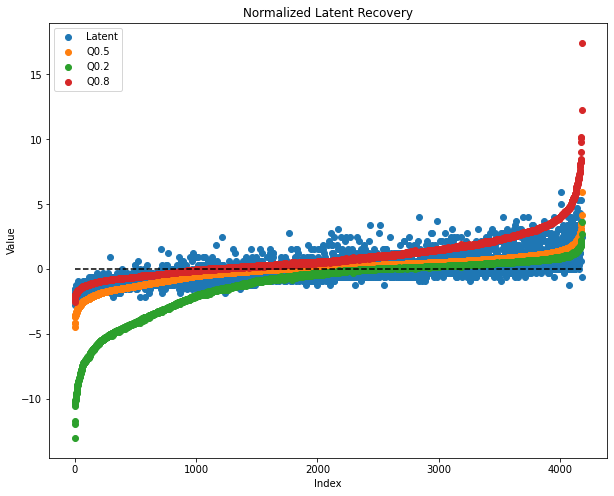

In [9]:
print("Latent Recovery:")
plt.figure(figsize=(10,8))
indices = np.argsort(all_preds[4], axis=None)
index_values = range(len(indices))
scaled_q50 = normalize(np.array(all_preds[4]),median_mean, median_std)
scaled_q20 = normalize(np.array(all_preds[1]),median_mean, median_std)
scaled_q80 = normalize(np.array(all_preds[7]),median_mean, median_std)

plt.scatter(index_values, cmp_Y[indices], label="Latent")
plt.scatter(index_values, scaled_q50[indices], label="Q0.5")
plt.scatter(index_values, scaled_q20[indices], label="Q0.2")
plt.scatter(index_values, scaled_q80[indices], label="Q0.8")
plt.plot([0,len(indices)], [0,0], linestyle="dashed", c="k")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Normalized Latent Recovery")
plt.show()

---

# Confidence score based metrics

The next section covers the Delta-Based metrics. Here we compute the confidence score (delta) of each sample, and find the misclassification ratio of all samples belonging to a specific delta. In general, the likelihood of a sample with a certain delta being misclassified is 0.5-delta.

With this knowledge, we can set a task specific minimum delta value. If delta is below an acceptable confidence score, we refuse to make a prediction because we are not confident about it

In addition, at each delta, we include a retention rate parameter. This is because while it might make sense to only consider points above a certain threshold, we could lose a significant amount of points in the process. The per delta retention rate gives an idea of how well the classifier has managed to learn

In [10]:
# Delta based results - Misclassification Rate and Retention Rate

misc_rate_results = "Misc. Rate |"
delta_header      = "Delta      |"
ret_rate_results  = "Ret.  Rate |"

for i in range(5):
    delta_header += "{:.2f}".format(0.1*(i+1)) + " | "
    total_samples = sum(misc_total[i])
    total_misc = sum(misc_delta[i])
    v2sum = 0
    for j in range(len(misc_total[i])):
        if misc_total[i][j] != 0:
            v2sum += misc_delta[i][j] /misc_total[i][j] 
    v2ratio = v2sum/len(misc_total[i])
    misc_rate_results += "{:.2f}".format(v2ratio) + " | "

print("Misclassification vs Delta Results:")
print(delta_header)
print(misc_rate_results)

print()

print("Retention Rate vs Delta Results:")
print(delta_header)
for ret_rate in accept_total:
    ret_rate_results += "{:.2f}".format(np.mean(ret_rate)/len(data_Y)) + " | "
print(ret_rate_results)

Misclassification vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Misc. Rate |0.40 | 0.34 | 0.27 | 0.16 | 0.04 | 

Retention Rate vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Ret.  Rate |1.00 | 0.85 | 0.70 | 0.55 | 0.37 | 


In the cell below, the Per-Delta AUC-ROC curves and FP Curves are plotted

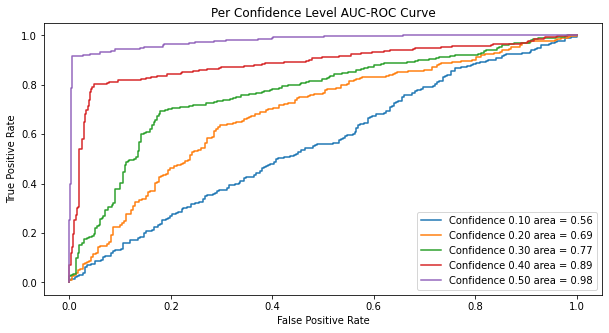

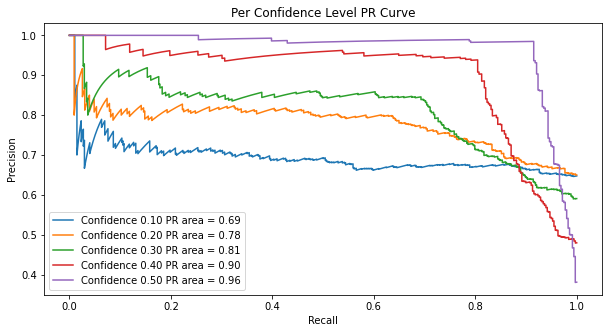

In [11]:
prec_array = []
recall_array = []
area_array_pr = []
area_array_roc = []
conf_array = []
fpr_array =[]
tpr_array =[]

for i in range(5):
    if len(samples_per_conf_level[i])!=0:
        fpr, tpr, _ = roc_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_roc.append(auc(fpr, tpr))
        fpr_array.append(fpr)
        tpr_array.append(tpr)
        precision, recall, thresholds = precision_recall_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_pr.append(auc(recall,precision))
        prec_array.append(precision)
        recall_array.append(recall)
        conf_array.append(i+1)


plt.figure(figsize=(10,5))
plt.title("Per Confidence Level AUC-ROC Curve")
for i in range(len(area_array_roc)):
    plt.plot(fpr_array[i], tpr_array[i], label='Confidence {:.2f} area = {:.2f}'.format(conf_array[i]*0.1, area_array_roc[i]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()        
        
        

plt.figure(figsize=(10,5))
plt.title("Per Confidence Level PR Curve")
for i in range(len(area_array_pr)):
    plt.plot(recall_array[i], prec_array[i], label='Confidence {:.2f} PR area = {:.2f}'.format(conf_array[i]*0.1, area_array_pr[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

---
# LALR for the BQR Loss

This final section covers the Lipschitz Adaptive Learning Rate. We create 3 identical classifiers, using SGD and compute the number of epochs required to reach a target accuracy.

In [12]:
# Set the target accuracy here
target_acc = 0.8
print_trigger = 10 # No. of epochs in between prints
max_epochs = 100 # Max no. of epochs

In [13]:
X_train,X_val,y_train,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, separator,
                                                                                    split_ratio, mv, Scaler,remove_head)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_cov = torch.Tensor(data_X)
y_cov = torch.Tensor(all_classes)
cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
cov_loader = data_utils.DataLoader(cov_dataset, batch_size =512, pin_memory=True,shuffle=False,num_workers = 1)

train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size = batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =512,pin_memory=True,shuffle = False,num_workers = 1)

indim = X_train.shape[1]

model_fixed = Network(indim)
model_fixed = model_fixed.to(device)
optimizer_fixed = torch.optim.SGD(model_fixed.parameters(), lr = 0.01)

model_adapt = Network(indim)
model_adapt = model_adapt.to(device)
optimizer_adapt = torch.optim.SGD(model_adapt.parameters(), lr = lr_is)

acc_train_fixed_1 = 0
acc_train_fixed_2 = 0
acc_test_fixed_1 = 0
acc_test_fixed_2 = 0
acc_train_adapt = 0
acc_test_adapt = 0

epoch_count_fixed_1 = 0
epoch_count_fixed_2 = 0
epoch_count_adapt = 0

et_1 = 0
et_2 = 0
et_adapt = 0

while (acc_train_fixed_1 < target_acc) and epoch_count_fixed_1<max_epochs:
    fixed_start = time.time()
    acc_train_fixed_1 = train(model_fixed,optimizer_fixed,train_loader, epoch_count_fixed_1)
    fixed_end = time.time()
    if epoch_count_fixed_1==0:
        timeval = (fixed_end-fixed_start)/60
        print("Epoch time: {:.4f}".format(timeval))
        et_1 = timeval
    acc_test_fixed_1  = test(model_fixed,cov_loader,epoch_count_fixed_1)
    if epoch_count_fixed_1 %print_trigger ==0:
        print("Fixed epoch:", epoch_count_fixed_1+1, "{:.3f} {:.3f}".format(acc_train_fixed_1, acc_test_fixed_1))
    epoch_count_fixed_1 +=1
print("LR 0.01 Complete")
print(acc_train_fixed_1, acc_test_fixed_1)
print("--------")

model_fixed = Network(indim)
model_fixed = model_fixed.to(device)
optimizer_fixed = torch.optim.SGD(model_fixed.parameters(), lr = 0.1)

while (acc_train_fixed_2 < target_acc) and epoch_count_fixed_2<max_epochs:
    fixed_start = time.time()
    acc_train_fixed_2 = train(model_fixed,optimizer_fixed,train_loader, epoch_count_fixed_2)
    fixed_end = time.time()
    if epoch_count_fixed_2==0:
        timeval = (fixed_end-fixed_start)/60
        print("Epoch time: {:.4f}".format(timeval))
        et_2 = timeval
    acc_test_fixed_2  = test(model_fixed,cov_loader,epoch_count_fixed_2)
    if epoch_count_fixed_2 %print_trigger ==0:
        print("Fixed epoch:", epoch_count_fixed_2+1, "{:.3f} {:.3f}".format(acc_train_fixed_2, acc_test_fixed_2))
    epoch_count_fixed_2 +=1
print("LR 0.1 Complete")
print(acc_train_fixed_2, acc_test_fixed_2)
print("--------")


epoch_count_adapt = 0
while (acc_train_adapt < target_acc):
    adapt_start = time.time()
    acc_train_adapt = train_adaptive_lr(model_adapt,optimizer_adapt,train_loader, epoch_count_adapt)
    adapt_end = time.time()
    if epoch_count_adapt==0:
        print("Epoch time: {:.4f}".format((adapt_end-adapt_start)/60))
        et_adapt = (adapt_end-adapt_start)/60
    acc_test_adapt  = test(model_adapt,cov_loader,epoch_count_adapt)
    if epoch_count_adapt %50 == 0:
        print("Adapt epoch:", epoch_count_adapt+1, "{:.3f} {:.3f}".format(acc_train_adapt, acc_test_adapt))
    epoch_count_adapt +=1
print("LR 0.1 Complete")
print(acc_train_adapt, acc_test_adapt)
print("--------")



Epoch time: 0.0207
Fixed epoch: 1 0.594 0.705
Fixed epoch: 11 0.734 0.733
Fixed epoch: 21 0.731 0.731
Fixed epoch: 31 0.732 0.731
Fixed epoch: 41 0.732 0.732
Fixed epoch: 51 0.735 0.734
Fixed epoch: 61 0.736 0.735
Fixed epoch: 71 0.738 0.737
Fixed epoch: 81 0.740 0.739
Fixed epoch: 91 0.740 0.739
LR 0.01 Complete
0.7395989224783 0.7392865693081159
--------
Epoch time: 0.0205
Fixed epoch: 1 0.635 0.740
Fixed epoch: 11 0.753 0.753
Fixed epoch: 21 0.790 0.793
Fixed epoch: 31 0.798 0.801
LR 0.1 Complete
0.8006584854833882 0.8015322001436438
--------
Epoch time: 0.0240
Adapt epoch: 1 0.629 0.718
LR 0.1 Complete
0.8006584854833882 0.7984199186018673
--------


In [14]:
print("LR Type    | Epochs | Time Per Epoch")
print("Fixed 0.01 | {}     | {:.2f}".format(epoch_count_fixed_1, et_1))
print("Fixed 0.1  | {}     | {:.2f}".format(epoch_count_fixed_2, et_2))
print("LALR       | {}     | {:.2f}".format(epoch_count_adapt, et_adapt))

LR Type    | Epochs | Time Per Epoch
Fixed 0.01 | 100     | 0.02
Fixed 0.1  | 33     | 0.02
LALR       | 14     | 0.02
